In [15]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
%matplotlib inline 
from sklearn.decomposition import PCA

import tempfile, sys, os
from keras.models import Model
sys.path.insert(0, os.path.abspath('..'))
from matplotlib.ticker import MultipleLocator
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D
from numpy import loadtxt
from keras.models import load_model
from keras import backend as K
import deepexplain
#from deepexplain.tensorflow import DeepExplain

In [2]:
train = pd.read_csv("data/3Classes_train.csv", sep="\t")
valid = pd.read_csv("data/3Classes_valid.csv", sep="\t")

y_train = train["Global classifier2"]
y_valid = valid["Global classifier2"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [3]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'test sequences')

4015 train sequences
709 test sequences


In [4]:
max_len = len(max(x_train, key=len))
print(max_len)

1500


In [5]:
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [6]:
cat = ['Mostly Cytosolic', 'Mostly Nuclear', 'Mostly Organellar']

tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [7]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [8]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [9]:
# Function to convert sequences to array of indices. I will that that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [10]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [11]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (4015, 1500)
x_valid shape: (709, 1500)


In [12]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [13]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

# First Model

Saved in model, folder 1 

In [22]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

In [18]:
max_features = tot_aa +1
batch_size = 32

model = Sequential()
model.add(Embedding(max_features, 64, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile('NAdam', 'categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='models/1/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                               verbose=1, save_best_only=True)

print('Train...')
model.fit(x_train_pad, y_train_OH,
          batch_size=batch_size,
          epochs=50, 
          class_weight= class_weights,
          validation_data=[x_valid_pad, y_valid_OH],
          callbacks=[checkpointer])

Train...
Train on 4015 samples, validate on 709 samples
Epoch 1/50
4015/4015 [==============================] - 188s 47ms/step - loss: 1.0303 - accuracy: 0.4715 - val_loss: 1.0150 - val_accuracy: 0.4838

Epoch 00001: val_loss improved from inf to 1.01503, saving model to models/1/weights.01-1.02.hdf5
Epoch 2/50
4015/4015 [==============================] - 188s 47ms/step - loss: 0.9846 - accuracy: 0.4984 - val_loss: 1.0159 - val_accuracy: 0.4908

Epoch 00002: val_loss did not improve from 1.01503
Epoch 3/50
4015/4015 [==============================] - 188s 47ms/step - loss: 1.0146 - accuracy: 0.4874 - val_loss: 1.0129 - val_accuracy: 0.4908

Epoch 00003: val_loss improved from 1.01503 to 1.01293, saving model to models/1/weights.03-1.01.hdf5
Epoch 4/50
4015/4015 [==============================] - 187s 47ms/step - loss: 1.0102 - accuracy: 0.4904 - val_loss: 1.0135 - val_accuracy: 0.4894

Epoch 00004: val_loss did not improve from 1.01293
Epoch 5/50
4015/4015 [============================

In [14]:
model = load_model('models/1/weights.46-0.58.hdf5')
plot_model(model, to_file='models/1/model_plot.png', show_shapes=True, show_layer_names=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [15]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_labels = indices_to_cat(y_pred_indices)

In [20]:
model.evaluate(x_valid_pad,y_valid_OH)

709/709 [==============================] - 8s 11ms/step


[0.5831989122000333, 0.7898448705673218]

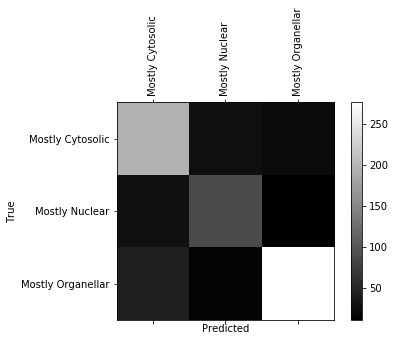

In [16]:
conf_mx = confusion_matrix(y_valid, y_pred_labels, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
conf_mx

array([[195,  27,  23],
       [ 28,  89,  11],
       [ 44,  16, 276]])

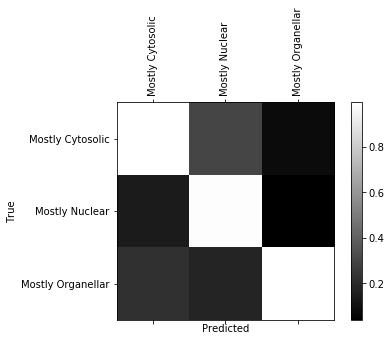

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Second Model 

I tried Adadelta, but the accuracy improves extremely slowly, same for SGD.
I couldn't reach the same accuracy then with NAdam.
RMSprop and SGD do not learn anything. 

I, therefore, deleted the trained models. Let's keep NAdam

Also tried embedding size of 32 with LSTM of 128, not as good as first model, I suspect embedding size should not be too small.

In [26]:
max_features = tot_aa +1
batch_size = 64

model2 = Sequential()
model2.add(Embedding(max_features, 64, input_length=max_len, 
                     name='embedding_layer', trainable=True))
model2.add(Bidirectional(LSTM(64, dropout = 0.15, recurrent_dropout=0.15)))
model2.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model2.compile('NAdam', 'categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='models/2/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                               verbose=1, save_best_only=True)

print('Train...')
history = model2.fit(x_train_pad, y_train_OH,
          batch_size=batch_size,
          epochs=50, 
          class_weight= class_weights,
          validation_data=[x_valid_pad, y_valid_OH],
          callbacks=[checkpointer])

Train...
Train on 4015 samples, validate on 709 samples
Epoch 1/50
4015/4015 [==============================] - 151s 37ms/step - loss: 1.0291 - accuracy: 0.4677 - val_loss: 1.4544 - val_accuracy: 0.1946

Epoch 00001: val_loss improved from inf to 1.45437, saving model to models/2/weights.01-1.45.hdf5
Epoch 2/50
4015/4015 [==============================] - 149s 37ms/step - loss: 1.0158 - accuracy: 0.4819 - val_loss: 1.0244 - val_accuracy: 0.4767

Epoch 00002: val_loss improved from 1.45437 to 1.02444, saving model to models/2/weights.02-1.02.hdf5
Epoch 3/50
4015/4015 [==============================] - 158s 39ms/step - loss: 0.9916 - accuracy: 0.4999 - val_loss: 0.9478 - val_accuracy: 0.5247

Epoch 00003: val_loss improved from 1.02444 to 0.94778, saving model to models/2/weights.03-0.95.hdf5
Epoch 4/50
4015/4015 [==============================] - 157s 39ms/step - loss: 0.9777 - accuracy: 0.5168 - val_loss: 0.9849 - val_accuracy: 0.4937

Epoch 00004: val_loss did not improve from 0.94778

4015/4015 [==============================] - 151s 38ms/step - loss: 0.5256 - accuracy: 0.7965 - val_loss: 0.5590 - val_accuracy: 0.7870

Epoch 00038: val_loss did not improve from 0.55682
Epoch 39/50
4015/4015 [==============================] - 152s 38ms/step - loss: 0.5162 - accuracy: 0.8030 - val_loss: 0.5501 - val_accuracy: 0.7870

Epoch 00039: val_loss improved from 0.55682 to 0.55007, saving model to models/2/weights.39-0.55.hdf5
Epoch 40/50
4015/4015 [==============================] - 150s 37ms/step - loss: 0.5181 - accuracy: 0.8037 - val_loss: 0.5716 - val_accuracy: 0.7757

Epoch 00040: val_loss did not improve from 0.55007
Epoch 41/50
4015/4015 [==============================] - 153s 38ms/step - loss: 0.5109 - accuracy: 0.8065 - val_loss: 0.5558 - val_accuracy: 0.7884

Epoch 00041: val_loss did not improve from 0.55007
Epoch 42/50
4015/4015 [==============================] - 148s 37ms/step - loss: 0.5030 - accuracy: 0.8120 - val_loss: 0.5543 - val_accuracy: 0.7814

Epoch 00042:

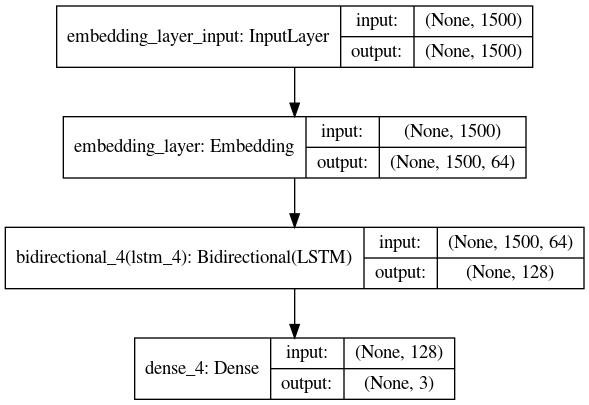

In [32]:
plot_model(model2, to_file='models/2/model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
model2 = load_model('models/2/weights.50-0.54.hdf5')
model2.evaluate(x_valid_pad,y_valid_OH)

709/709 [==============================] - 9s 12ms/step


[0.5429465517674918, 0.7870239615440369]

In [38]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer_input (Input (None, 1500)              0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 1500, 64)          1472      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 67,907
Trainable params: 67,907
Non-trainable params: 0
_________________________________________________________________


In [19]:
y_pred2 = model2.predict(x_valid_pad)
y_pred_indices2 = OH_to_label_indices(y_pred2)
y_pred_labels2 = indices_to_cat(y_pred_indices2)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred_labels2, target_names=cat))

                   precision    recall  f1-score   support

 Mostly Cytosolic       0.74      0.81      0.77       245
   Mostly Nuclear       0.63      0.72      0.67       128
Mostly Organellar       0.91      0.80      0.85       336

         accuracy                           0.79       709
        macro avg       0.76      0.77      0.76       709
     weighted avg       0.80      0.79      0.79       709



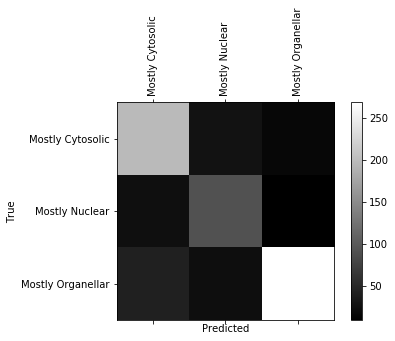

In [20]:
conf_mx2 = confusion_matrix(y_valid, y_pred_labels2, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx2, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

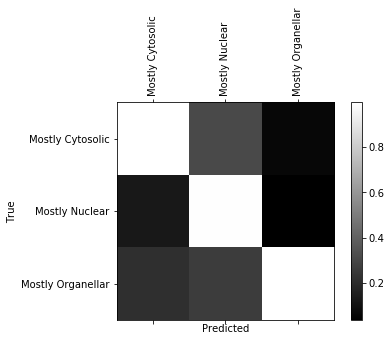

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx2 / (conf_mx2.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

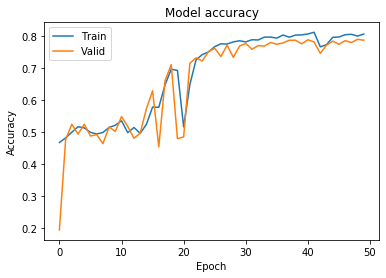

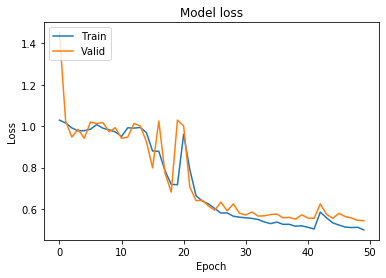

In [27]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [55]:
# Get the Embedding Layer
model2 = load_model("models/2/weights.50-0.54.hdf5")
model2.evaluate(x_valid_pad, y_valid_OH)

709/709 [==============================] - 8s 12ms/step


[0.5429465517674918, 0.7870239615440369]

In [46]:
embedding = model2.get_layer('embedding_layer').get_weights()
embedding = embedding[0]
embedding.shape

(23, 64)

In [47]:
# PCA plots of Embedding 
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)

original shape:    (23, 64)
transformed shape: (23, 2)


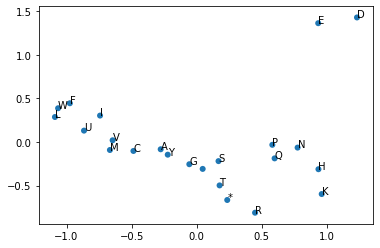

In [50]:
fig, ax = plt.subplots()
plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1], edgecolor='none')
aaL = list(aa)
for i in range(len(aaL)):
    ax.annotate(aaL[i], (embedding_pca[:, 0][i], embedding_pca[:, 1][i]))
    

plt.show()

### Error Analysis

In [28]:
valid["Model Prediction"] = y_pred_labels2

In [30]:
valid.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh,Model Prediction
0,Q96MN5,Mostly Organellar,MDKFVIRTPRIQNSPQKKDSGGKVYKQATIESLKRVVVVEDIKRWK...,208,Mostly Nuclear
1,P42575,Mostly Cytosolic,MAAPSAGSWSTFQHKELMAADRGRRILGVCGMHPHHQETLKKNRVV...,452,Mostly Cytosolic
2,Q9NZP8,Mostly Organellar,MPGPRVWGKYLWRSPHSKGCPGAMWWLLLWGVLQACPTRGSVLLAQ...,487,Mostly Organellar
3,Q96K80,Mostly Nuclear,MPDRDSYANGTGSSGGGPGGGGSEEASGAGVGSGGASSDAICRDFL...,434,Mostly Nuclear
4,Q86TA1,Mostly Cytosolic,MSIALKQVFNKDKTFRPKRKFEPGTQRFELHKRAQASLNSGVDLKA...,216,Mostly Cytosolic


In [32]:
valid.groupby(["Global classifier2", "Model Prediction"]).count()/len(valid)*100

Lead Protein ID   Sequence  \
Global classifier2 Model Prediction                                
Mostly Cytosolic   Mostly Cytosolic         27.926657  27.926657   
                   Mostly Nuclear            4.090268   4.090268   
                   Mostly Organellar         2.538787   2.538787   
Mostly Nuclear     Mostly Cytosolic          3.667137   3.667137   
                   Mostly Nuclear           12.976023  12.976023   
                   Mostly Organellar         1.410437   1.410437   
Mostly Organellar  Mostly Cytosolic          6.064880   6.064880   
                   Mostly Nuclear            3.526093   3.526093   
                   Mostly Organellar        37.799718  37.799718   

                                      Sequence Lengh  
Global classifier2 Model Prediction                   
Mostly Cytosolic   Mostly Cytosolic        27.926657  
                   Mostly Nuclear           4.090268  
                   Mostly Organellar        2.538787  
Mostly Nuclear     Mostly Cytosolic         3.667137  
                   Mostly Nuclear          12.976023  
                   Mostly Organellar        1.410437  
Mostly Organellar  Mostly Cytosolic         6.064880  
                   Mostly Nuclear           3.526093  
                   Mostly Organellar       37.799718

In [33]:
# THIS CODE OUTPUT THE INDICES FOR CORRECT AND INCORRECT EXEMPLES.
corrects = []
falses = []
for x in range(len(y_valid)):
    if y_valid_indices[x] == y_pred_indices2[x]:
        corrects.append(x)
    else:
        falses.append(x)

In [34]:
print('There is ' + str(len(corrects)) + ' correctly classified exemples')
print('There is ' + str(len(falses)) + ' incorrectly classified exemples')
print('So the accuracy is: ' + str(len(corrects)/len(x_valid)*100))

There is 558 correctly classified exemples
There is 151 incorrectly classified exemples
So the accuracy is: 78.70239774330042


In [35]:
corrects_df = valid[valid.index.isin(corrects)]
falses_df = valid[valid.index.isin(falses)]

In [37]:
falses_df.head()

,Lead Protein ID,Global classifier2,Sequence,Sequence Lengh,Model Prediction
0,Q96MN5,Mostly Organellar,MDKFVIRTPRIQNSPQKKDSGGKVYKQATIESLKRVVVVEDIKRWK...,208,Mostly Nuclear
8,P82663,Mostly Organellar,MPMKGRFPIRRTLQYLSQGNVVFKDSVKVMTVNYNTHGELGEGARK...,173,Mostly Cytosolic
15,Q92802,Mostly Nuclear,MSYGEIEGKFLGPREEVTSEPRCKKLKSTTESYVFHNHSNADFHRI...,583,Mostly Cytosolic
17,Q6ICC9,Mostly Cytosolic,MVQPQTSKAESPALAASPNAQMDDVIDTLTSLRLTNSALRREASTL...,239,Mostly Nuclear
19,Q6IQ19,Mostly Organellar,MSPGSGVKSEYMKRYQEPRWEEYGPCYRELLHYRLGRRLLEQAHAP...,270,Mostly Nuclear


# Model 3: CNN LSTM

https://keras.io/examples/imdb_cnn_lstm/

In [68]:
max_features = tot_aa +1
batch_size = 32

# Convolution
kernel_size = 15
filters = 48
pool_size = 4

model = Sequential()
model.add(Embedding(max_features, 64, input_length=max_len, name= 'embedding_layer'))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='same',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(80, dropout = 0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile('NAdam', 'categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='models/3/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                               verbose=1, save_best_only=False)

print('Train...')
history = model.fit(x_train_pad, y_train_OH,
          batch_size=batch_size,
          epochs=25, 
          class_weight= class_weights,
          validation_data=[x_valid_pad, y_valid_OH],
          callbacks=[checkpointer])

Train...
Train on 4015 samples, validate on 709 samples
Epoch 1/25
4015/4015 [==============================] - 85s 21ms/step - loss: 0.9740 - accuracy: 0.5078 - val_loss: 0.8765 - val_accuracy: 0.5853

Epoch 00001: saving model to models/3/weights.01-0.88.hdf5
Epoch 2/25
4015/4015 [==============================] - 82s 20ms/step - loss: 0.8806 - accuracy: 0.5676 - val_loss: 0.8527 - val_accuracy: 0.5952

Epoch 00002: saving model to models/3/weights.02-0.85.hdf5
Epoch 3/25
4015/4015 [==============================] - 84s 21ms/step - loss: 0.8800 - accuracy: 0.5724 - val_loss: 0.8684 - val_accuracy: 0.5543

Epoch 00003: saving model to models/3/weights.03-0.87.hdf5
Epoch 4/25
4015/4015 [==============================] - 83s 21ms/step - loss: 0.6999 - accuracy: 0.6956 - val_loss: 0.6376 - val_accuracy: 0.7320

Epoch 00004: saving model to models/3/weights.04-0.64.hdf5
Epoch 5/25
4015/4015 [==============================] - 87s 22ms/step - loss: 0.6189 - accuracy: 0.7497 - val_loss: 0.59

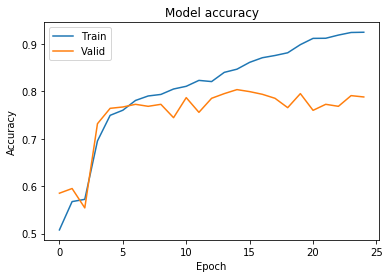

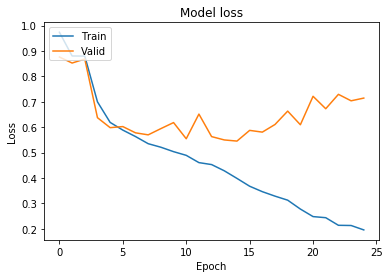

In [69]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

Notes:
    
    CNN LSTM train really fast
    I need to optimize kernel size and filter size 
    Then, need to check if it work with attention 
    I could try to find a way to combine different filter size
    
Tested:

    kernel_size = 12, filters = 64, padding = valid, LSTM(64, 0.2, 0.2), strongly overfit after 15 epoch 
    kernel_size = 9, filters = 32, padding = valid LSTM(64, 0.2, 0.2), did not perform as good as first
    kernel_size = 15, filters = 48, padding = same LSTM(64, 0.2, 0.2), best so far
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


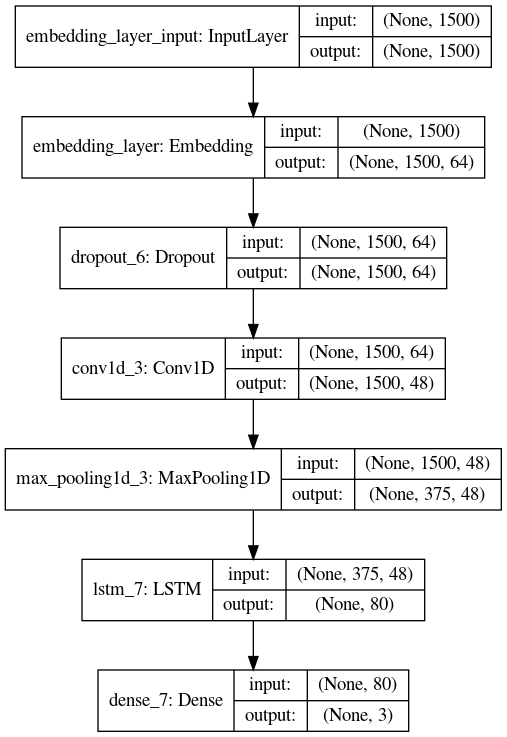

In [14]:
model3 = load_model('models/3/weights.15-0.55.hdf5')
plot_model(model3, to_file='models/3/model_plot.png', show_shapes=True, show_layer_names=True)

In [72]:
model3.evaluate(x_valid_pad,y_valid_OH)

709/709 [==============================] - 5s 7ms/step


[0.5454247957686611, 0.803949236869812]

In [76]:
y_pred3 = model.predict(x_valid_pad)
y_pred_indices3 = OH_to_label_indices(y_pred3)
y_pred_labels3 = indices_to_cat(y_pred_indices3)

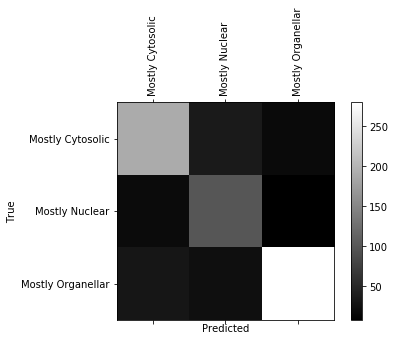

In [77]:
conf_mx3 = confusion_matrix(y_valid, y_pred_labels3, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx3, cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

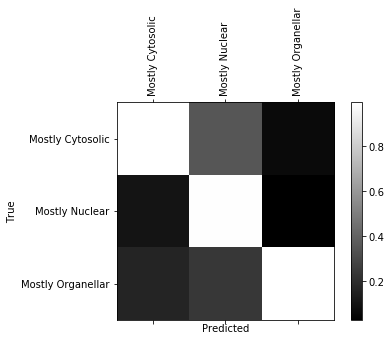

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx3 / (conf_mx3.max(axis=0)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Embedding

In [73]:
embedding = model3.get_layer('embedding_layer').get_weights()
embedding = embedding[0]
embedding.shape

(23, 64)

In [74]:
# PCA plots of Embedding 
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)

original shape:    (23, 64)
transformed shape: (23, 2)


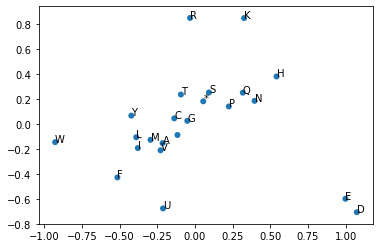

In [75]:
fig, ax = plt.subplots()
plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1], edgecolor='none')
aaL = list(aa)
for i in range(len(aaL)):
    ax.annotate(aaL[i], (embedding_pca[:, 0][i], embedding_pca[:, 1][i]))
    

plt.show()

## Checking the model on the test set

In [52]:
test = pd.read_csv("data/3Classes_test.csv", sep="\t")
y_test = test["Global classifier2"]
y_test_indices = cat_to_indices(y_test)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

x_test = test["Sequence"].copy()
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len, value=aa_to_int["*"])

In [53]:
score = model.evaluate(x_test_pad, y_test_OH, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5222583223375485
Test accuracy: 0.821342945098877


In [56]:
score2 = model2.evaluate(x_test_pad, y_test_OH, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

Test loss: 0.4906710890843142
Test accuracy: 0.8045563697814941


In [82]:
score3 = model3.evaluate(x_test_pad, y_test_OH, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

Test loss: 0.500200130599294
Test accuracy: 0.8153477311134338
